# Define helper functions

In [1]:
# Import necessary libraries
import torch
from torchvision import models, transforms
from torchvision.utils import make_grid
from torchvision.models import ResNet50_Weights
from torchvision.io import read_image

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from art.attacks.evasion import FastGradientMethod
from art.estimators.classification import PyTorchClassifier
from AdaIN_pytorch.utils import adaptive_instance_normalization
from AdaIN_pytorch.AdaIN import AdaINNet
from pathlib import Path
from torch.utils import model_zoo
from collections import OrderedDict
import pandas as pd


# Function to load and preprocess an image
def load_and_preprocess_image(image_path, transform):
    image = Image.open(image_path)
    image = transform(image)
    return image

# Function to unnormalize and display images
def imshow(img, title=None):
    img = img.detach()  # Detach the tensor from the computation graph
    img = img.cpu()  # Move tensor to CPU
    # Reverse the normalization
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img = img * std + mean  # Unnormalize
    img = torch.clamp(img, 0, 1)  # Clip to ensure pixel values are within [0, 1]
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))  # Change from (C, H, W) to (H, W, C)
    plt.imshow(npimg)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

# Function to carry out inference
def inference(model, images, classes):
    model.eval()
    with torch.no_grad():
        outputs = model(images)
        _, indices = torch.sort(outputs, descending=True)
        percentage = torch.nn.functional.softmax(outputs, dim=1) * 100
        results = []
        for i in range(images.size(0)):
            result = [(classes[idx], percentage[i][idx].item()) for idx in indices[i][:5]]
            results.append(result)
    return results

# Function to load class labels
def load_classes(file_path):
    with open(file_path) as f:
        classes = [line.strip() for line in f.readlines()]
    return classes

# Function to transform images
def get_transform():
    return transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),


    ])

# Function to create adversarial examples using FGSM
def create_adversarial_examples(model, images, epsilon=0.9):
    # Get the min and max pixel values of the dataset
    min_pixel_value, max_pixel_value = images[0].min(), images[0].max()

    # Create PyTorch classifier
    classifier = PyTorchClassifier(
        model=model,
        loss=torch.nn.CrossEntropyLoss(),
        optimizer=torch.optim.Adam(model.parameters(), lr=0.01),
        input_shape=(3, 224, 224),
        nb_classes=1000,
        clip_values=(min_pixel_value, max_pixel_value),
        device_type='cpu'
    )

    # Create FGSM attack
    attack = FastGradientMethod(estimator=classifier, eps=epsilon)

    # Generate adversarial test examples
    adversarial_images = attack.generate(x=images.numpy())
    return torch.from_numpy(adversarial_images)

# Function to apply style transfer
def style_transfer(content_tensor, style_tensor, encoder, decoder, alpha=1.0):
    content_enc = encoder(content_tensor)
    style_enc = encoder(style_tensor)
    transfer_enc = adaptive_instance_normalization(content_enc, style_enc)
    mix_enc = alpha * transfer_enc + (1 - alpha) * content_enc
    return decoder(mix_enc)

# Function to display results as separate tables
def display_results_as_tables(results):
    # Loop over the results for each image
    for i, res in enumerate(results):
        # Initialize an empty list to collect rows
        rows = []
        
        for label, score in res:
            # Append the result as a dictionary to the list
            rows.append({'Label': label, 'Score': f"{score:.2f}%"})

        # Create DataFrame from the list of rows
        df = pd.DataFrame(rows, columns=['Label', 'Score'])

        # Display the DataFrame with the image number as the title
        print(f"\nTop predictions for Image {i+1}:")
        print(df)


# Load models and images

In [2]:
# Initialize the Weight Transforms
weights = ResNet50_Weights.DEFAULT
transform = weights.transforms()

# # Get tranfrom to stack images as tensors
# transform = get_transform()

# Load and preprocess images
dog_img = load_and_preprocess_image('./dog.jpg',transform=transform)
# cat_img = load_and_preprocess_image('./cat.jpg', transform)
apple_img = load_and_preprocess_image('./green_apple.jpg',transform=transform)

x_test = torch.stack([dog_img, apple_img])

# Load model and classes
resnet = models.resnet50(weights=ResNet50_Weights.DEFAULT)
classes = load_classes('./imagenet_classes.txt')

# Load pretrained model of ResNet on Stylized ImageNet (Resnet_SIN)
resnet_sin = models.resnet50(weights=None)
url = 'https://bitbucket.org/robert_geirhos/texture-vs-shape-pretrained-models/raw/6f41d2e86fc60566f78de64ecff35cc61eb6436f/resnet50_train_60_epochs-c8e5653e.pth.tar'

checkpoint = model_zoo.load_url(url, map_location=torch.device('cpu'))

# Remove prefix module. for all keys in checkpoint['state_dict']
new_state_dict = OrderedDict()
for k, v in checkpoint['state_dict'].items():
    name = k[7:]  # remove `module.`
    new_state_dict[name] = v

# Load the new state dict
resnet_sin.load_state_dict(new_state_dict)

<All keys matched successfully>

## Display original images and perform inference on both ResNet and ResNet_SIN models

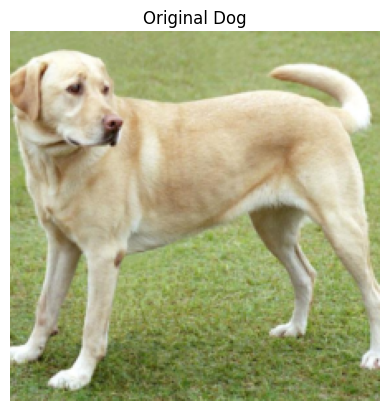

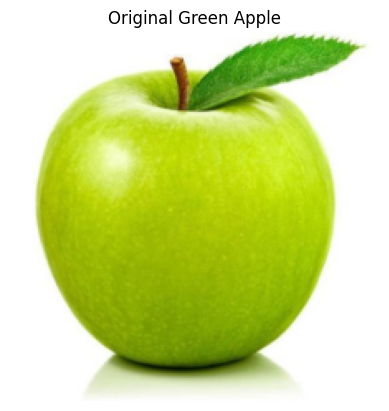

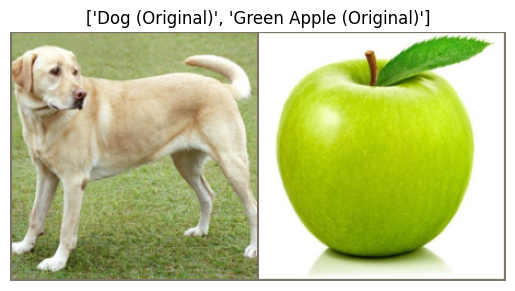

Original images inference on Resnet50:

Top predictions for Image 1:
                      Label   Score
0        Labrador retriever  12.63%
1  Chesapeake Bay retriever   2.76%
2                Eskimo dog   1.35%
3                    kelpie   1.26%
4          golden retriever   0.82%

Top predictions for Image 2:
          Label   Score
0  Granny Smith  40.56%
1         lemon   0.35%
2        orange   0.22%
3        banana   0.19%
4           fig   0.14%

Original images inference on Resnet50_SIN:

Top predictions for Image 1:
                Label   Score
0  Labrador retriever  54.09%
1    golden retriever  17.45%
2               dingo   6.26%
3              Saluki   4.10%
4              kuvasz   2.87%

Top predictions for Image 2:
           Label   Score
0   Granny Smith  99.90%
1          lemon   0.03%
2         orange   0.02%
3  custard apple   0.02%
4            fig   0.01%


In [3]:
imshow(x_test[0], title='Original Dog')
imshow(x_test[1], title='Original Green Apple')

# Display images in a grid
imshow(make_grid(x_test), title=['Dog (Original)', 'Green Apple (Original)'])


# Perform inference on original images
print("Original images inference on Resnet50:")
results = inference(resnet, x_test, classes)
display_results_as_tables(results)
     
# Perform inference on original images using the stylized model
print("\nOriginal images inference on Resnet50_SIN:")
results_sin = inference(resnet_sin, x_test, classes)
display_results_as_tables(results_sin)

   

## Create adversarial examples using FGSM on ResNet and perform inference

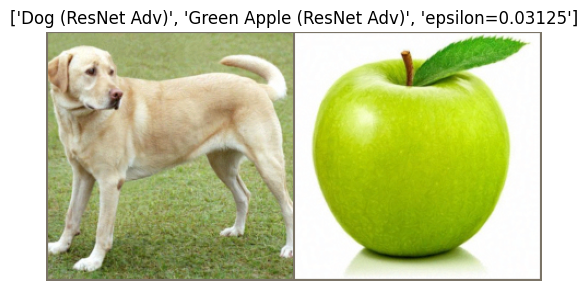

Adversarial images inference using original resnet with epsilon=0.03125:

Top predictions for Image 1:
                      Label  Score
0  Chesapeake Bay retriever  2.51%
1                Eskimo dog  1.78%
2        Labrador retriever  1.53%
3                     dingo  0.73%
4            Siberian husky  0.61%

Top predictions for Image 2:
          Label   Score
0  Granny Smith  21.55%
1         lemon   0.44%
2   tennis ball   0.31%
3        orange   0.28%
4       pitcher   0.22%


In [4]:
# Define epsilon values
epsilon = 8/256

# Create adversarial examples for original ResNet model
x_test_adv_resnet = create_adversarial_examples(resnet, x_test, epsilon=epsilon)

# Display adversarial examples
imshow(make_grid(x_test_adv_resnet), title=['Dog (ResNet Adv)', 'Green Apple (ResNet Adv)', f'{epsilon=}'])

# # # Save x_test_adv_resnet as image
# x_test_adv_resnet = x_test_adv_resnet.permute(0, 2, 3, 1).numpy()
# x_test_adv_resnet = (x_test_adv_resnet).astype(np.uint8)
# Image.fromarray(x_test_adv_resnet[0]).save('dog_adv.jpg')
# Image.fromarray(x_test_adv_resnet[1]).save('green_apple_adv.jpg')
# # 
# # # Load images back to x_test_adv_resnet
# x_test_adv_resnet = torch.stack([read_image('dog_adv.jpg'), read_image('green_apple_adv.jpg')]).to(torch.float32)


# Perform inference on adversarial examples using the original model
print(f"Adversarial images inference using original resnet with {epsilon=}:")
results_adv = inference(resnet, x_test_adv_resnet, classes)
display_results_as_tables(results_adv)

## Create adversarial examples using FGSM on ResNet_SIN and perform inference

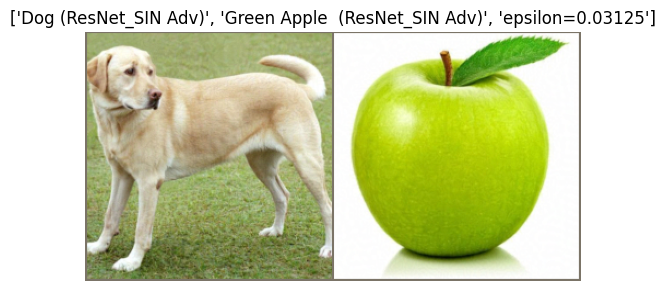


Adversarial images inference using resnet_SIN with epsilon=0.03125:

Top predictions for Image 1:
              Label   Score
0            Saluki  51.20%
1           basenji  19.56%
2             dingo   5.03%
3  golden retriever   3.21%
4   standard poodle   2.36%

Top predictions for Image 2:
           Label   Score
0   Granny Smith  81.45%
1    tennis ball   4.57%
2          lemon   1.58%
3  custard apple   1.39%
4         orange   1.36%


In [5]:
# Create adversarial examples for ResNet_SIN model
x_test_adv_resnet_sin = create_adversarial_examples(resnet_sin, x_test, epsilon=epsilon)

# Display adversarial examples
imshow(make_grid(x_test_adv_resnet_sin), title=['Dog (ResNet_SIN Adv)', 'Green Apple  (ResNet_SIN Adv)', f'{epsilon=}'])
        
# Perform inference on adversarial examples using the stylized model
print(f"\nAdversarial images inference using resnet_SIN with {epsilon=}:")
results_adv_stylized = inference(resnet_sin, x_test_adv_resnet_sin, classes)
display_results_as_tables(results_adv_stylized)
        

## Load AdaIN model

In [6]:
# Load AdaIN model
vgg = torch.load('./AdaIN_pytorch/vgg_normalized.pth')
model = AdaINNet(vgg).to('cpu')  # Assuming CPU for demonstration
model.decoder.load_state_dict(torch.load('./AdaIN_pytorch/decoder.pth'))
model.eval()

AdaINNet(
  (encoder): Sequential(
    (0): Conv2d(3, 3, kernel_size=(1, 1), stride=(1, 1))
    (1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16): ReLU(inplace=True)
    

## Configure style transfer and alpha value

In [7]:
# Select and load style image
style_image = Path('AdaIN_pytorch/images/texture/paper_texture.jpg')
style_img = load_and_preprocess_image(style_image, transform)

# Define alpha value
alpha = 0.8

## Perform style transfer on adversarial examples from ResNet and ResNet_SIN models

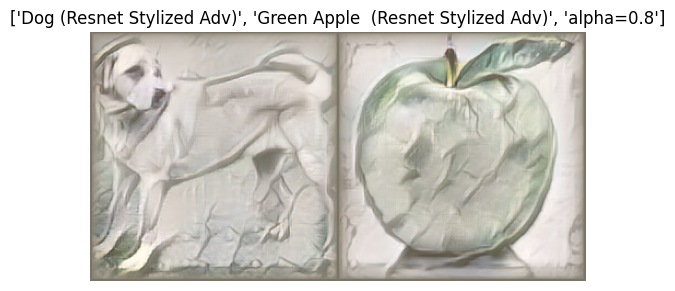

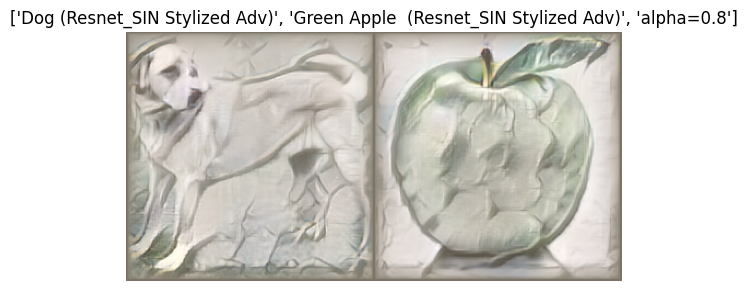

In [8]:
# Perform style transfer on adversarial examples from ResNet model
x_test_adv_resnet_stylized = [style_transfer(img.unsqueeze(0), style_img.unsqueeze(0), model.encoder, model.decoder,alpha=alpha) for img in x_test_adv_resnet]
x_test_adv_resnet_stylized = torch.cat(x_test_adv_resnet_stylized)

# Display stylized adversarial examples
imshow(make_grid(x_test_adv_resnet_stylized), title=['Dog (Resnet Stylized Adv)', 'Green Apple  (Resnet Stylized Adv)',f'{alpha=}'])

# Perform inference on stylized adversarial examples from ResNet_SIN model
x_test_adv_resnet_sin_stylized = [style_transfer(img.unsqueeze(0), style_img.unsqueeze(0), model.encoder, model.decoder,alpha=alpha) for img in x_test_adv_resnet_sin]

# Display stylized adversarial examples
x_test_adv_resnet_sin_stylized = torch.cat(x_test_adv_resnet_sin_stylized)

# Display stylized adversarial examples
imshow(make_grid(x_test_adv_resnet_sin_stylized), title=['Dog (Resnet_SIN Stylized Adv)', 'Green Apple  (Resnet_SIN Stylized Adv)',f'{alpha=}'])



## Perform inference on stylized adversarial examples

In [9]:

# Perform inference on stylized adversarial examples using ResNet model
print("Stylized adversarial ResNet images inference:")
print('--------------------------------------------')
results_stylized_adv = inference(resnet, x_test_adv_resnet_stylized, classes)
display_results_as_tables(results_stylized_adv)


# Perform inference on stylized adversarial examples using ResNet_SIN model
print("\nStylized adversarial ResNet_SIN images inference:")
print('--------------------------------------------')
results_stylized_adv = inference(resnet_sin, x_test_adv_resnet_sin_stylized, classes)
display_results_as_tables(results_stylized_adv)

Stylized adversarial ResNet images inference:
--------------------------------------------

Top predictions for Image 1:
          Label  Score
0   oxygen mask  4.51%
1       mailbag  3.52%
2  sleeping bag  2.28%
3   plastic bag  1.90%
4         boxer  1.55%

Top predictions for Image 2:
            Label  Score
0    head cabbage  7.82%
1         pitcher  4.14%
2            vase  3.67%
3  soap dispenser  2.19%
4            tray  2.07%

Stylized adversarial ResNet_SIN images inference:
--------------------------------------------

Top predictions for Image 1:
                Label   Score
0              kuvasz  62.53%
1      Great Pyrenees   9.88%
2    golden retriever   9.04%
3  Labrador retriever   4.26%
4              Saluki   1.65%

Top predictions for Image 2:
          Label   Score
0  Granny Smith  99.96%
1           fig   0.01%
2         lemon   0.01%
3   bell pepper   0.01%
4        orange   0.00%


## Apply style transfer on original images

In [10]:
# Function to create a grid of images
def create_image_grid(tensor, nrow=1, padding=2):
    # Check if the input is a list of tensors or a single batched tensor
    if isinstance(tensor, list):
        tensor = torch.stack(tensor)

    # Determine the size of each image
    n, c, h, w = tensor.shape
    ncol = (n + nrow - 1) // nrow

    # Create a blank canvas for the grid
    grid_height = nrow * h + (nrow - 1) * padding
    grid_width = ncol * w + (ncol - 1) * padding
    grid = torch.full((c, grid_height, grid_width), 1.0)  # Using 1.0 to create white padding

    # Place each image onto the canvas
    for idx in range(n):
        row = idx // ncol
        col = idx % ncol
        top = row * (h + padding)
        left = col * (w + padding)
        grid[:, top:top+h, left:left+w] = tensor[idx]

    return grid

torch.Size([2, 3, 224, 224])


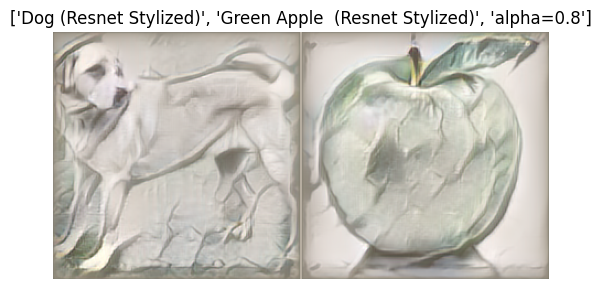

Stylized ResNet images inference:
--------------------------------------------

Top predictions for Image 1:
          Label  Score
0       mailbag  5.30%
1        Saluki  2.61%
2   breastplate  2.18%
3  sleeping bag  2.00%
4   plastic bag  1.66%

Top predictions for Image 2:
            Label   Score
0    head cabbage  10.20%
1         pitcher   6.48%
2          candle   5.28%
3            vase   4.38%
4  soap dispenser   4.09%

Stylized ResNet_SIN images inference:
--------------------------------------------

Top predictions for Image 1:
                Label   Score
0              kuvasz  55.97%
1  Labrador retriever  20.83%
2      Great Pyrenees  10.35%
3    golden retriever   3.99%
4       Saint Bernard   1.06%

Top predictions for Image 2:
          Label   Score
0  Granny Smith  99.97%
1           fig   0.01%
2         lemon   0.01%
3   bell pepper   0.00%
4        orange   0.00%


In [11]:
x_test_stylized = [style_transfer(img.unsqueeze(0), style_img.unsqueeze(0), model.encoder, model.decoder,alpha=alpha) for img in x_test]
x_test_stylized = torch.cat(x_test_stylized)
print(x_test_stylized.shape)
# Display stylized images
imshow(create_image_grid(x_test_stylized), title=['Dog (Resnet Stylized)', 'Green Apple  (Resnet Stylized)',f'{alpha=}'])

# Perform inference on stylized images using ResNet model
print("Stylized ResNet images inference:")
print('--------------------------------------------')
results_stylized = inference(resnet, x_test_stylized, classes)
display_results_as_tables(results_stylized)

# Perform inference on stylized images using ResNet_SIN model
print("\nStylized ResNet_SIN images inference:")
print('--------------------------------------------')
results_stylized = inference(resnet_sin, x_test_stylized, classes)
display_results_as_tables(results_stylized)

In [12]:
# Load image without adversarial examples from path
path_no_adv = '/mobileye/RPT/users/kfirs/kfir_project/non_adversarials_subset/binoculars/image_331.jpg'
path_adv = '/mobileye/RPT/users/kfirs/kfir_project/adversarials_subset/binoculars/image_331.npy'

# Load and preprocess images
no_adv_img = load_and_preprocess_image(path_no_adv,transform=transform)

# Load npy file to PIL image
adv_image = np.load(path_adv).squeeze().astype(np.uint8)
adv_image = Image.fromarray(adv_image)

adv_image_tensor = transform(adv_image)

x_test_no_adv = torch.stack([no_adv_img, adv_image_tensor])

# Perform inference on original images
print("Original images inference on Resnet50:")
results = inference(resnet, x_test_no_adv, classes)
display_results_as_tables(results)

Original images inference on Resnet50:

Top predictions for Image 1:
        Label   Score
0  binoculars  26.14%
1       mouse   0.63%
2     ocarina   0.41%
3       loupe   0.37%
4    joystick   0.36%

Top predictions for Image 2:
        Label   Score
0  binoculars  36.44%
1  sunglasses   0.64%
2       mouse   0.64%
3       loupe   0.37%
4    lens cap   0.35%
